In [6]:
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

In [7]:
import sys
sys.path.append("../")

In [8]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragments.pkl")
with fragments_path.open("rb") as fh:
  fragments = pickle.load(fh)

CPU times: user 26.7 s, sys: 3.56 s, total: 30.2 s
Wall time: 30.3 s


In [9]:
results = fragments

In [10]:
N_max = -1
angle_fragments = []
bond_fragments = []
for i,result in enumerate(fragments):
  if i<N_max or N_max == -1:
    angle_fragments+=result["angle_fragments"]
    bond_fragments+=result["bond_fragments"]

In [11]:
from phenixml.featurizers.ani_featurizer import ANIFeaturizer

In [12]:
# elements and parameters
covalent_organic = ["O","C","H","N","P","S","Cl","B","F","I","Br"]
metals = ["Na","K","Ca","Fe","Mn","Zn","Mg","Cu","Co"]

params = {'radial_cutoff': 4.6,
 'radial_nu': 32,
 'radial_probes': [0.7,
                  1.4,
                  1.9,
                  2.4,
                  3.2,
                  3.8,
                  4.4],
 'angular_cutoff': 3.1,
 'angular_nu': 4,
 'angular_probes': [0.0, 1.57, 3.14, 4.71],
 'angular_radial_probes': [0.7,1.4,1.9,2.4],
 'angular_zeta': 8,
 'min_probed_value': 0.0,
 'exclude_hydrogens': False,
 'elements_considered': covalent_organic}

In [28]:
import numpy as np
from sklearn.neighbors import KDTree
from itertools import combinations

# # sample parameter dict
# params = {'radial_cutoff': 4.6,
#  'radial_nu': 32,
#  'radial_probes': [0.7,
#                   1.4,
#                   1.9,
#                   2.4,
#                   3.2,
#                   3.8,
#                   4.4],
#  'angular_cutoff': 3.1,
#  'angular_nu': 4,
#  'angular_probes': [0.0, 1.57, 3.14, 4.71],
#  'angular_radial_probes': [0.7,1.4,1.9,2.4],
#  'angular_zeta': 8,
#  'min_probed_value': 0.0,
#  'exclude_hydrogens': False,
#  'elements_considered': ["O","C","H","N","P","S","Cl","B","F","I","Br"]}




class ANIFeaturizer:
  
  @classmethod
  def from_bond_angle_frags(cls,frags,params):
    rdmols = [frag.rdmol for frag in frags]
    if len(set(rdmols))==1:

      rdmol = rdmols[0]
      interaction_mols = [rdmol]
      target_fragments = frags

      frags_midpoints = np.array([target.xyz_fragment.mean(axis=0) for target in target_fragments])
      assert(frags_midpoints.shape[1]==3)
      target_xyz = frags_midpoints
      interaction_xyz = np.vstack([rdmol.GetConformer().GetPositions() for rdmol in interaction_mols])
      interaction_elements = np.concatenate([[a.GetSymbol() for a in rdmol.GetAtoms()] for rdmol in interaction_mols])

      return cls(target_xyz,interaction_xyz,interaction_elements,params)
    else:
      return None
  
  
  def __init__(self,target_xyz,interaction_xyz,interaction_elements,params,calc_mode="optimized",debug=False):
    self.params = params
    self.target_xyz = target_xyz
    self.interaction_xyz = interaction_xyz

    
    self.n_targets = len(target_xyz)
    self.interaction_inds = np.array([i for i,element in enumerate(interaction_elements) if element in self.params["elements_considered"]])
    self.interaction_elements = [interaction_elements[i] for i in self.interaction_inds]
    
    
    self.calc_mode = calc_mode
    self.debug = debug
    
    # set parameters
    self.rc_rad = self.params["radial_cutoff"]
    self.nu_rad = self.params["radial_nu"]
    self.rs_rad = np.array(self.params["radial_probes"])
    self.rc_ang = self.params["angular_cutoff"]
    self.rs_ang = np.array(self.params["angular_radial_probes"])
    self.ts = np.array(self.params["angular_probes"])
    self.nu_ang = self.params["angular_nu"]
    self.zeta = self.params["angular_zeta"]
  
    self.radial_elements = sorted(set(self.params["elements_considered"]))
    self.angular_elements = [ij for ij in list(combinations(self.radial_elements,2))]+[(e,e) for e in self.radial_elements]
    self.angular_elements = [tuple(sorted(ij)) for ij in self.angular_elements]

    # calculate immediately
    
    

  def featurize(self):
    gr,ga = self.gr,self.ga
    return np.hstack([gr,ga])
  
  @property
  def ga(self):
    if not hasattr(self,"_ga"):
      if self.calc_mode == "simple":
        _ga = self.calc_angular_simple()
      elif self.calc_mode == "optimized":
        _ga = self.calc_angular_optimized()
    return _ga
  
  @property
  def gr(self):
    if not hasattr(self,"_gr"):
      if self.calc_mode == "simple":
        _gr = self.calc_radial_simple()
      elif self.calc_mode == "optimized":
        _gr = self.calc_radial_optimized()
    return _gr
  
  
  @property
  def kdtree_interact(self):
    if not hasattr(self,"_kdtree_interact"):
      self._kdtree_interact = KDTree(self.interaction_xyz)
    return self._kdtree_interact
  
  @staticmethod
  def fc_vect(rij, rc):

    return np.piecewise(rij, [rij <= rc, rij > rc],
                        [lambda x: (0.5 * np.cos((np.pi * x) / rc) + 0.5), 0])
  
  def calc_radial_simple(self,return_flat=True,debug=False):
    n_targets = self.n_targets
    n_rad = len(self.radial_elements)
    n_rs = len(self.rs_rad)
    if debug:
      self.ij_inds = [] #debug
    radial_vector = np.zeros((n_targets,n_rad,n_rs))
    for i,i_xyz in enumerate(self.target_xyz):
      for j,element_j in enumerate(self.interaction_elements):
        j_xyz = self.interaction_xyz[j]
        rij = np.linalg.norm(i_xyz-j_xyz)
        if rij>0:
          gr = np.zeros(n_rs)

          if rij>self.rc_rad:
            pass # set all to zero
          else:
            fc = 0.5 * np.cos((np.pi*rij)/self.rc_rad) + 0.5

            for r,rs in enumerate(self.rs_rad):
              gr[r]+=np.exp(-self.nu_rad*(rij-rs)**2)*fc
              
            if debug:
              self.ij_inds.append([i,j]) # debug
          
          e = self.radial_elements.index(element_j)
          radial_vector[i,e]+=gr

    if not  return_flat:
      return radial_vector
    else:
      return radial_vector.reshape((n_targets,n_rad*n_rs))
  
  def calc_radial_optimized(self,return_flat=True):
    
    
    rc_rad = self.rc_rad
    n_targets = self.n_targets
    n_rs = len(self.rs_rad)
    n_rad = len(self.radial_elements)

    inds,dists = self.kdtree_interact.query_radius(self.target_xyz, self.rc_rad,return_distance=True)
    ij_inds = np.array([(i,j) for i,ind in enumerate(inds) for j_idx,j in enumerate(ind) if dists[i][j_idx]>0])

    gr = np.zeros((n_targets,n_rad,n_rs))
    if len(ij_inds)>0:

      nu_rad = self.nu_rad
      rs_rad = self.rs_rad

      rad_i = ij_inds[:,0]
      rad_j = ij_inds[:,1]
      rad_xyz_i = self.target_xyz[rad_i]
      rad_xyz_j = self.interaction_xyz[rad_j]

      rad_xyz_ij = rad_xyz_j - rad_xyz_i

      rad_xyz_ij = rad_xyz_j - rad_xyz_i
      rad_rij = np.linalg.norm(rad_xyz_ij, axis=1)

      fc = self.fc_vect(rad_rij, self.rc_rad)

      radial = np.exp(-self.nu_rad*(rad_rij[:,np.newaxis]-self.rs_rad)**2) * fc[:,np.newaxis]

      for n,(i,j) in enumerate(ij_inds):
        ej = self.interaction_elements[j]
        component_index = self.radial_elements.index(ej)
        gr[i,component_index]+=radial[n]
    if return_flat:
      gr = gr.reshape((n_targets,n_rad*n_rs))
    return gr
  
  def calc_angular_simple(self,return_flat=True,debug=True):
    n_targets = self.n_targets
    n_interactions = len(self.interaction_inds)
    n_ang = len(self.angular_elements)
    n_rs = len(self.rs_ang)
    n_ts = len(self.ts)
    
    if debug:
      self.debug_dict_ang = {}
      self.ijk_triples = []
    angular_vector = np.zeros((n_targets,n_ang,n_ts,n_rs))
    
    for i,i_xyz in enumerate(self.target_xyz):
      for j,element_j in enumerate(self.interaction_elements):
        for k,element_k in enumerate(self.interaction_elements):
          if j!=k:
            j_xyz = self.interaction_xyz[j]
            k_xyz = self.interaction_xyz[k]
            rij = np.linalg.norm(i_xyz-j_xyz)
            rik = np.linalg.norm(i_xyz-k_xyz)
            if rij > 0 and rik>0:
              
              ga = np.zeros((n_ts,n_rs))
              if rij>self.rc_ang or rik>self.rc_ang:
                pass
              else:
                self.ijk_triples.append([i,j,k])
                fcij = 0.5 * np.cos((np.pi*rij)/self.rc_ang) + 0.5
                fcik = 0.5 * np.cos((np.pi*rik)/self.rc_ang) + 0.5          

                for t,ts in enumerate(self.ts):
                  # i,j,k == b,a,c
                  ba = j_xyz-i_xyz
                  bc = k_xyz-i_xyz
                  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
                  angle_tol = 1e-4
                  if cosine_angle > 1:
                    assert(cosine_angle-1 < angle_tol)
                    cosine_angle = 1.0
                  elif cosine_angle <-1:
                    assert(cosine_angle+1 < angle_tol)
                    cosine_angle = -1.0

                  tijk= np.arccos(cosine_angle)
                  angular_term = (1+np.cos(tijk-ts))**self.zeta

                  for r,rs in enumerate(self.rs_ang):            
                    radial_term = np.exp(-self.nu_ang*(((rij+rik)/2)-rs)**2)
                    ga[t,r]=angular_term * radial_term * fcij * fcik


                  # match to an angular component
                  element_pair = tuple(sorted([element_j,element_k]))
                  if element_pair in self.angular_elements:
                    a = self.angular_elements.index(element_pair)
                  else:
                    print("ERROR: j,k element pair not in full element list")


                    # debug
                    if debug:
                      key = (i,j,k,ts,rs)
                      assert(key not in self.debug_dict_ang)
                      self.debug_dict_ang[key] = {}
                      self.debug_dict_ang[key]["tijk"] = tijk
                      self.debug_dict_ang[key]["rij"] = rij
                      self.debug_dict_ang[key]["rik"] = rik
                      self.debug_dict_ang[key]["fcij"] = fcij
                      self.debug_dict_ang[key]["fcik"] = fcik
                      self.debug_dict_ang[key]["angular_term"] = angular_term
                      self.debug_dict_ang[key]["radial_term"] = radial_term
                      self.debug_dict_ang[key]["combined"] = angular_term * radial_term * fcij * fcik
                      self.debug_dict_ang[key]["combined_scaled"] = 2**(1-self.zeta) * (angular_term * radial_term * fcij * fcik)
                      self.debug_dict_ang[key]["ek"] = element_pair[0]+"."+element_pair[1]


              angular_vector[i,a]+=ga
              
    angular_vector*= 2**(1-self.zeta)
    if return_flat:
      return angular_vector.reshape((n_targets,n_ang*n_rs*n_ts))
    else:
      return angular_vector
    
  def calc_angular_optimized(self,return_flat=True,debug=True):
    n_targets = self.n_targets
    n_interactions = len(self.interaction_inds)
    n_ang = len(self.angular_elements)
    n_rs_ang = len(self.rs_ang)
    n_ts = len(self.ts)
    rc_ang = self.rc_ang

    n_ang = len(self.angular_elements)

    inds,dists = self.kdtree_interact.query_radius(self.target_xyz, rc_ang,return_distance=True)

    # new_inds will remove the self pairs
    new_inds = []
    for i,ind in enumerate(inds):
      new_ind = []
      for j,n in enumerate(ind):
        d = dists[i][j]
        if d>0:
          new_ind.append(n)
      new_inds.append(new_ind)

    ijk_inds = [(i, j, k) for i, ind in enumerate(new_inds) for j, k in combinations(ind, 2) if j!=k]
    ijk_inds += [(i,k, j) for i, ind in enumerate(new_inds) for j, k in combinations(ind, 2) if j!=k]
    ijk_inds = np.array(ijk_inds)
    # Note: The above will do redundant calculations. Calculate every i,j,k and i,k,j pair. This is
    #       done for consistency with previous code and to make debugging easier
    
    
    if debug:
      self.ijk_inds = ijk_inds
    ga = np.zeros((n_targets,n_ang,n_ts,n_rs_ang))

    if len(ijk_inds)>0:
      xyz_i = self.target_xyz[ijk_inds[:,0]]
      xyz_j = self.interaction_xyz[ijk_inds[:,1]]
      xyz_k = self.interaction_xyz[ijk_inds[:,2]]

      xyz_ij = xyz_j - xyz_i
      xyz_ik = xyz_k - xyz_i

      rij = np.linalg.norm(xyz_ij, axis=1)
      rik = np.linalg.norm(xyz_ik, axis=1)

      # calculate the angle between ijk sites, centered on site i
      cosine_angle = np.einsum('ij,ij->i', xyz_ij, xyz_ik) / (rij * rik)
      neg_inds, = np.where(cosine_angle<-1)
      pos_inds, = np.where(cosine_angle>1)
      cosine_angle[neg_inds] = -1.0
      cosine_angle[pos_inds] = 1.0
      tijk = np.arccos(cosine_angle)


      # calculate angular and modified radial components of the environment vector (see Equation 4)
      angular = (1 + np.cos(tijk[:, np.newaxis] - self.ts)) ** self.zeta
      radial = np.exp(-self.nu_ang * (((rij + rik) / 2)[:, np.newaxis] - self.rs_ang) ** 2)

      # calculate the radial weights (see Equation 2)
      fcij = self.fc_vect(rij, self.rc_ang)
      fcik = self.fc_vect(rik, self.rc_ang)

      # multiply all pieces, broadcasts to shape (l,m,n) where l indexes the triples,
      # m the ts values, n the rs values
      ang_mult = angular[:, :, np.newaxis] * radial[:, np.newaxis, :] * \
           fcij[:, np.newaxis, np.newaxis] * fcik[:, np.newaxis, np.newaxis]


      for n,(i,j,k) in enumerate(ijk_inds):
        ek = tuple(sorted([self.interaction_elements[j],self.interaction_elements[k]]))
        component_index = self.angular_elements.index(ek)
        ga[i,component_index]+=ang_mult[n]
    if return_flat:
      ga = ga.reshape((n_targets,n_ang*n_ts*n_rs_ang))
    ga*=(2**(1-self.zeta))

    if debug:
      for key,value in locals().items():
        key = "debug_ang_"+key
        setattr(self,key,value)
    return ga


In [29]:
def worker_angle(result):
  featurizer = ANIFeaturizer.from_bond_angle_frags(result["angle_fragments"],params)
  return featurizer.featurize()

def worker_bond(result):
  featurizer = ANIFeaturizer.from_bond_angle_frags(result["bond_fragments"],params)
  if featurizer is None:
    return None
  else:
    return featurizer.featurize()
  #return featurizer

In [30]:
# work = results
# with closing(Pool(processes=32)) as pool:
#   angle_features = []
#   for result in tqdm.tqdm(pool.map(worker_angle, work), total=len(work)):
#       angle_features.append(result)
#   pool.terminate()

In [31]:
work = results
with closing(Pool(processes=64)) as pool:
  bond_features = []
  for result in tqdm.tqdm(pool.map(worker_bond, work), total=len(work)):
      bond_features.append(result)
  pool.terminate()

100%|██████████| 63018/63018 [00:00<00:00, 1641198.44it/s]


In [64]:
N_max = -1
bond_fragments = []
X = []
for i,feature in enumerate(bond_features):
  if i<N_max or N_max ==-1:
    if feature is not None:
      bond_fragments+=results[i]["bond_fragments"]
      X.append(feature)
X = np.vstack(X)

In [65]:
X.shape

(1856810, 1133)

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [67]:
mode = "bond"
if mode =="bond":

  y =  np.array([frag.properties["bond_length"] for frag in bond_fragments])
  space = np.arange(X.shape[0])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
elif mode == "angle":
  X = angle_features
  y =  np.array([frag.properties["angle_deg"] for frag in angle_fragments])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [68]:
regressor = RandomForestRegressor(n_estimators=100,min_samples_split=2, random_state=0,n_jobs=-1)

In [69]:
%%time
regressor.fit(X_train,y_train)

CPU times: user 1d 4h 44min 54s, sys: 25min 44s, total: 1d 5h 10min 38s
Wall time: 31min 27s


RandomForestRegressor(n_jobs=-1, random_state=0)

In [72]:
y_pred = regressor.predict(X_test)

Text(0, 0.5, 'Predicted')

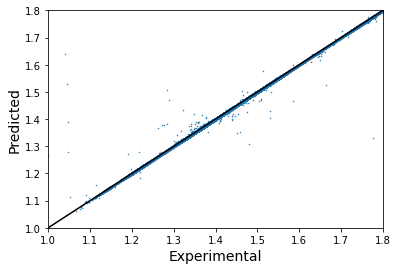

In [73]:
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [ ]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
residuals = y_test-y_pred
sns.histplot(residuals)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)